In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [2]:
# 检查 GPU 是否可用
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available


#### Virtual Data

In [3]:
'''
生成天气数据： 使用正弦函数模拟温度和湿度的周期性变化，并添加随机噪声。使用随机数生成风速数据。
添加天气数据到 DataFrame： 将生成的天气数据添加到 load_data 中。
生成日历数据： 使用 time_index.weekday 获取每个时间点对应的星期几，然后判断是否为周末，并假设没有节假日。
添加日历数据到 DataFrame： 将生成的日历数据添加到 load_data 中。
'''


#创建模拟数据集
np.random.seed(42)  # 设置随机种子，保证结果可复现

# 时间维度：一周7天，每天96个时间点（每15分钟一个）
time_index = pd.date_range(start='2024-01-01', end='2024-07-31 23:45', freq='15min')

# 空间维度：假设有3个变电站
# substations = ['A', 'B', 'C']




load_data = pd.DataFrame(index=time_index)
# 添加日历数据
load_data['Weekday'] = time_index.weekday  # 0: Monday, 1: Tuesday, ..., 6: Sunday
load_data['IsWeekend'] = load_data['Weekday'].isin([5, 6]).astype(int)  # 1: Weekend, 0: Weekday

# 添加天气数据
temperature = 20 + 10 * np.sin(2 * np.pi * (np.arange(len(time_index))-32) / 96) + np.random.rand(len(time_index)) * 5
humidity = 50 + 20 * np.sin(2 * np.pi * np.arange(len(time_index)) / 96) + np.random.rand(len(time_index)) * 10
wind_speed = 5 + 3 * np.random.rand(len(time_index))

load_data['Temperature'] = temperature
load_data['Humidity'] = humidity
load_data['WindSpeed'] = wind_speed
#load_data['IsHoliday'] = 0  # 假设没有节假日

# 模拟负荷数据：
# - 基本负荷：每个变电站有一个基本负荷值，在一天内波动
# - 随机噪声：添加随机噪声，模拟实际负荷的波动
#base_loads = {'A': 100, 'B': 150, 'C': 200}

base_loads =  200 + np.random.uniform(0.9,1.1) * 50 * np.abs(load_data['Temperature']-20)/15   # 每天的波动范围为0-50, 与温度有关
work_hours_variations = np.array([max(0,np.sin(np.pi * (i % 96-32) / 32))*200 for i in range(len(time_index))])*np.random.uniform(0.9,1.1,len(time_index)) *(1+np.abs((load_data['Humidity']-50)/240)) # 工作时间段的波动范围为0-100
noise = np.random.rand(len(time_index)) * 50  # 随机噪声
load_data['base_loads'] = base_loads + noise
load_data["work_hours"] = work_hours_variations
load_data["real_load"] = load_data["work_hours"] * (1-load_data["IsWeekend"])+ load_data['base_loads']


print(load_data.head())


                     Weekday  IsWeekend  Temperature   Humidity  WindSpeed  \
2024-01-01 00:00:00        0          0    13.212447  55.088214   7.952458   
2024-01-01 00:15:00        0          0    15.784844  60.527021   7.907493   
2024-01-01 00:30:00        0          0    14.421174  61.206200   7.741282   
2024-01-01 00:45:00        0          0    13.523991  63.589341   6.305941   
2024-01-01 01:00:00        0          0    11.120835  61.681172   5.500009   

                     base_loads  work_hours   real_load  
2024-01-01 00:00:00  244.721562         0.0  244.721562  
2024-01-01 00:15:00  225.573837         0.0  225.573837  
2024-01-01 00:30:00  265.233671         0.0  265.233671  
2024-01-01 00:45:00  262.074133         0.0  262.074133  
2024-01-01 01:00:00  277.203636         0.0  277.203636  


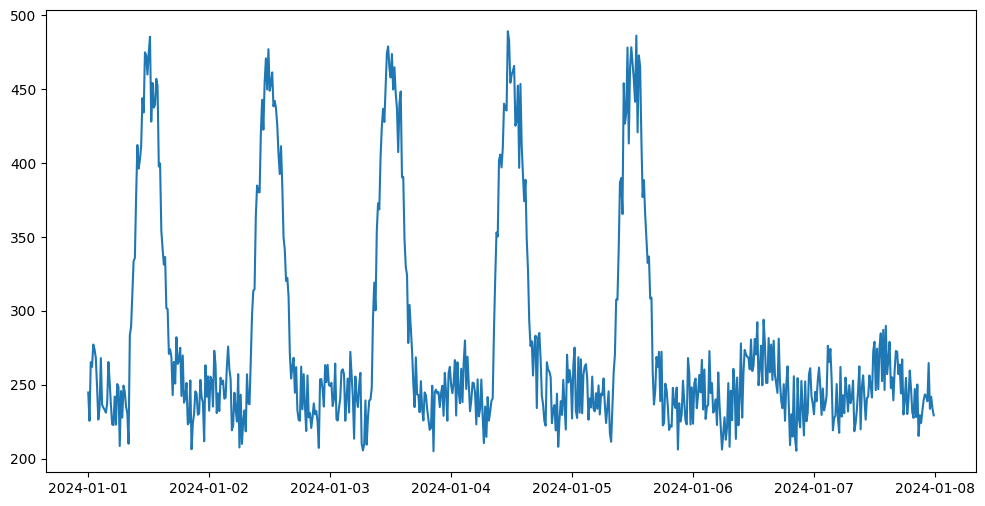

In [4]:
plt_data = load_data[:96*7]
fig = plt.figure(figsize=(12, 6))
plt.plot(plt_data.index, plt_data['real_load'], label='Real Load')

In [5]:
# 数据预处理
scaler = MinMaxScaler()  # 使用 MinMaxScaler 进行特征缩放
load_data[['real_load', 'Temperature', 'Humidity']] = scaler.fit_transform(load_data[['real_load', 'Temperature', 'Humidity']])

# 缺失值处理（如果需要）
load_data.fillna(method='ffill', inplace=True)  # 使用前一个值填充缺失值

# 特征选择
input_cols = ['real_load','IsWeekend','Temperature','Humidity',]

# 创建输入输出序列
def create_sequences(data, seq_length, target_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - target_length):
        x = data[i:(i + seq_length)].values
        y = data['real_load'][(i + seq_length):(i + seq_length + target_length)].values
        # y = data.loc[(i + seq_length):(i + seq_length + target_length), 'real_load'].values
        if i == 0:
            print(x.shape, y.shape)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 96*7   # 使用前七天的数据作为输入
target_length = 1

X, y = create_sequences(load_data[input_cols], seq_length, target_length)
print(X.shape, y.shape)
# 划分训练集和验证集
train_size = int(0.8 * len(X))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# 构建 DataLoader
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)

for i, batch in enumerate(val_loader):
    if i == 0:
        inputs, labels = batch
        print(labels[0])
        print(inputs[2])
        print(inputs.shape, labels.shape)


(672, 4) (1,)
(19775, 672, 4) (19775, 1)
tensor([0.0910])
tensor([[0.0771, 0.0000, 0.6106, 0.1810],
        [0.0456, 0.0000, 0.5408, 0.2123],
        [0.0998, 0.0000, 0.4164, 0.1014],
        ...,
        [0.0935, 0.0000, 0.5615, 0.0715],
        [0.0910, 0.0000, 0.5824, 0.0907],
        [0.0977, 0.0000, 0.5411, 0.2145]])
torch.Size([256, 672, 4]) torch.Size([256, 1])


#### Real Data

In [3]:
load_data = pd.read_csv(r'C:\Users\Georg\Desktop\TTRS\2-EMS\research\Forecasting\Data\106.csv', index_col='time', parse_dates=True)

In [10]:
load_data.drop(['season'], axis=1, inplace=True)

In [12]:
load_data

,Power,Temperature,weekday,hour
time,,,,
2024-01-22 16:30:00,0.653409,-2.4,0.0,16.0
2024-01-22 16:30:00,0.653409,-2.4,0.0,16.0
2024-01-22 16:30:00,0.653409,-2.4,0.0,16.0
2024-01-22 16:30:00,0.653409,-2.4,0.0,16.0
2024-01-22 16:30:00,0.653409,-2.4,0.0,16.0
...,...,...,...,...
2024-05-30 23:35:00,0.221591,26.8,3.0,23.0
2024-05-30 23:40:00,0.248106,26.8,3.0,23.0
2024-05-30 23:45:00,0.232955,26.8,3.0,23.0


In [14]:
# # 数据预处理
scaler1 = MinMaxScaler()  # 使用 MinMaxScaler 进行特征缩放
scaler2 = MinMaxScaler()  # 使用 MinMaxScaler 进行特征缩放
# load_data[['real_load', 'Temperature', 'Humidity']] = scaler.fit_transform(load_data[['real_load', 'Temperature', 'Humidity']])
load_data[['Power']] = scaler1.fit_transform(load_data[['Power']])
load_data[['Temperature','weekday','hour']] = scaler1.fit_transform(load_data[['Temperature','weekday','hour']])


# # 缺失值处理（如果需要）
load_data.fillna(method='ffill', inplace=True)  # 使用前一个值填充缺失值

# # 特征选择
# input_cols = ['real_load','IsWeekend','Temperature','Humidity',]
# input_cols = ['values','weekday','season']
input_cols = ['Power','Temperature','weekday','hour']



# 创建输入输出序列
def create_sequences(data, seq_length, target_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - target_length):
        x = data[i:(i + seq_length)].values
        y = data['Power'][(i + seq_length):(i + seq_length + target_length)].values
        # y = data.loc[(i + seq_length):(i + seq_length + target_length), 'real_load'].values
        if i == 0:
            print(x.shape, y.shape)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 288*4   # 使用前七天的数据作为输入
target_length = 1

X, y = create_sequences(load_data[input_cols], seq_length, target_length)
print(X.shape, y.shape)
# 划分训练集和验证集
train_size = int(0.8 * len(X))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# 构建 DataLoader
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)

for i, batch in enumerate(val_loader):
    if i == 0:
        inputs, labels = batch
        print(labels[0])
        print(inputs[0])
        print(inputs.shape, labels.shape)


(1152, 4) (1,)
(38203, 1152, 4) (38203, 1)
tensor([0.2140])
tensor([[0.2102, 0.6267, 0.8333, 0.7826],
        [0.2102, 0.6267, 0.8333, 0.7826],
        [0.2083, 0.6267, 0.8333, 0.7826],
        ...,
        [0.2083, 0.6267, 0.3333, 0.7826],
        [0.1856, 0.6267, 0.3333, 0.7826],
        [0.1629, 0.6267, 0.3333, 0.7826]])
torch.Size([256, 1152, 4]) torch.Size([256, 1])


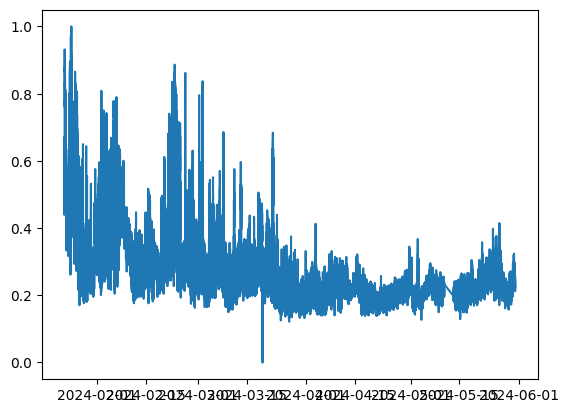

In [15]:
plt.plot(load_data['Power'])

### Transformer_encoder_only

In [16]:
# 2. Transformer Model Definition
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_dim, hidden_size, num_layers, num_heads, dropout):
        super().__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_size, nhead=num_heads, dim_feedforward=hidden_size, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.linear = nn.Linear(input_size, output_dim)
        self.activ = nn.ReLU()

    def forward(self, x):
        # print('x shape before transformer', x.shape)
        x = self.transformer_encoder(x)
        # print('x shape after transformer', x.shape)
        # x = torch.mean(x[:, -4:, :], dim = 1)
        x = x[:,-1,:]
        # print('x shape after mean', x.shape)
        x = self.linear(x)  # Take the output of the last time step
        # print('x shape after linear', x.shape)
        x = self.activ(x)
        # print('x shape after activation', x.shape)
        return x

In [11]:
# # 模型训练
# input_size = 4  # 输入特征维度
# output_dim = 1  # 输出特征维度
# hidden_size = 64  # 隐藏层维度
# batch_size = 128  # 批处理大小
# num_layers = 2
# num_heads = 4
# seq_length = 96*7  # 使用前七天的数据作为输入

# model_example = TransformerModel(input_size, output_dim, hidden_size, num_layers, num_heads, dropout=0.1).to(device)

# src = torch.rand(seq_length, batch_size, input_size).to(device)
# src = src.permute(1, 0, 2)
# target = torch.randn(batch_size, output_dim).to(device)
# output = model_example(src)  # teacher_forcing_ratio 可调
# print(output.shape, target.shape)

x shape before transformer torch.Size([128, 672, 4])
x shape after transformer torch.Size([128, 672, 4])
x shape after mean torch.Size([128, 4])
x shape after linear torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])


In [ ]:
# 模型训练
input_size = 4  # 输入特征维度
output_dim = 1  # 输出特征维度
hidden_size = 256  # 隐藏层维度
batch_size = 256  # 批处理大小
num_layers = 3
num_heads = 4
seq_length = 288*4  # 使用前七天的数据作为输入

model = TransformerModel(input_size, output_dim, hidden_size, num_layers, num_heads, dropout=0.1)
# criterion = nn.MSELoss()  
criterion = nn.MSELoss() # 添加L2正则化# 均方误差损失函数
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=1e-3,
                             weight_decay= 0.001)

model.to(device)
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        # inputs = inputs.permute(1,0,2)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # # Calculate L2 loss and add it to the main loss
        # l2_lambda = 0.001  # Regularization strength
        # l2_loss = 0
        # for param in model.parameters():
        #     l2_loss += torch.norm(param, p=2)**2 
        # loss = criterion(outputs, labels) + l2_lambda * l2_loss

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)

        
    # 在验证集上评估模型
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # inputs = inputs.permute(1,0,2)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}],Train_loss:{train_loss:.4f},Validation Loss: {val_loss:.4f}")

    # 保存模型
    #torch.save(model.state_dict(), 'load_forecasting_model.pth')

In [9]:
# 在验证集上进行预测
model.eval()
predictions = []
actual_values = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
        # print(inputs.shape, labels.shape)
        inputs = inputs.to(device)
        # inputs = inputs.permute(1, 0, 2)
        outputs = model(inputs)
        # print(outputs.shape, labels.shape)
        predictions.append(outputs.cpu().numpy())
        actual_values.append(labels.cpu().numpy())

predictions = np.concatenate(predictions)
actual_values = np.concatenate(actual_values)



In [10]:
predictions.shape, actual_values.shape

((3955, 1), (3955, 1))

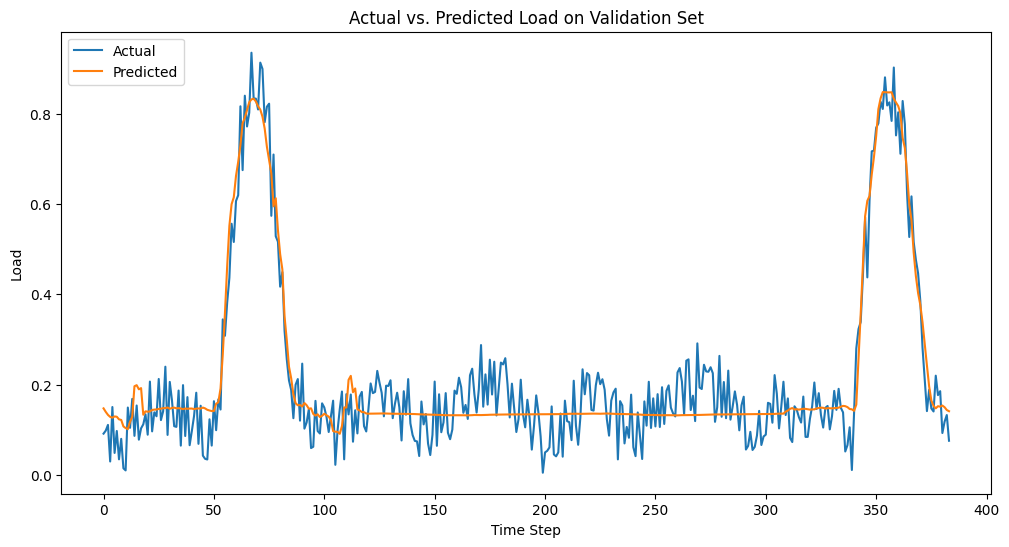

In [12]:
# 可视化预测值和实际值

plt.figure(figsize=(12, 6))
plt.plot(actual_values.flatten()[:96*4], label='Actual')
plt.plot(predictions.flatten()[:96*4], label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Load')
plt.legend()
plt.title('Actual vs. Predicted Load on Validation Set')
plt.show()

In [ ]:
for name, param in model.named_parameters():
        print(f"Name: {name}, Shape: {param.shape}, Gradient Required: {param.requires_grad}")

Name: encoder_layer.self_attn.in_proj_weight, Shape: torch.Size([12, 4]), Gradient Required: True
Name: encoder_layer.self_attn.in_proj_bias, Shape: torch.Size([12]), Gradient Required: True
Name: encoder_layer.self_attn.out_proj.weight, Shape: torch.Size([4, 4]), Gradient Required: True
Name: encoder_layer.self_attn.out_proj.bias, Shape: torch.Size([4]), Gradient Required: True
Name: encoder_layer.linear1.weight, Shape: torch.Size([256, 4]), Gradient Required: True
Name: encoder_layer.linear1.bias, Shape: torch.Size([256]), Gradient Required: True
Name: encoder_layer.linear2.weight, Shape: torch.Size([4, 256]), Gradient Required: True
Name: encoder_layer.linear2.bias, Shape: torch.Size([4]), Gradient Required: True
Name: encoder_layer.norm1.weight, Shape: torch.Size([4]), Gradient Required: True
Name: encoder_layer.norm1.bias, Shape: torch.Size([4]), Gradient Required: True
Name: encoder_layer.norm2.weight, Shape: torch.Size([4]), Gradient Required: True
Name: encoder_layer.norm2.bias